In [141]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf

In [151]:
class algo_trading():
    
    def __init__(self,tickers,period,interval,short,long):
        
        self.tickers = tickers
        self.period = period
        self.interval = interval
        self.long = long
        self.short = short 
        
        self.collect_data()
        self.indicator()
        self.Moving_average_reversal()
        self.returns() 
        self.analysis()       
        
    def collect_data(self):
        
        data = yf.download(tickers= self.tickers, period= self.period, interval=self.interval)
        data.index = pd.DatetimeIndex(data.index)
        self.data = data
    
    def indicator(self):
        
        self.data["daily_return"] = np.log(self.data['Close'].div(self.data['Close'].shift(1)))
        #self.data["daily_return"] = self.data['Close'].pct_change()
        self.data['MA_21'] = self.data['Close'].rolling(self.short).mean()
        self.data['MA_100'] = self.data['Close'].rolling(self.long).mean()
        self.data['MA_21_prev'] = self.data['MA_21'].shift()
        self.data['MA_100_prev'] = self.data['MA_100'].shift()
        self.data = self.data.dropna()
        return self.data
    
    def Moving_average_reversal(self):
        
        self.data['signal'] = np.where((self.data['MA_21'] > self.data['MA_100']) & (self.data['MA_21_prev'] < self.data['MA_100_prev']),1,0)
        self.data['signal'] = np.where((self.data['MA_21'] < self.data['MA_100']) & (self.data['MA_21_prev'] > self.data['MA_100_prev']),-1,self.data['signal'])
        self.data['signal'] = self.data['signal'].shift(-1)
        
        self.data['position'] = self.data['signal'].replace(to_replace = 0, method = 'ffill')
        self.data = self.data.dropna()
        return self.data['position'].value_counts()
 
    def returns(self):
        
        self.data['BUY_HOLD_return'] = self.data["daily_return"]
        self.data['Strategy_return'] = self.data['BUY_HOLD_return'] * self.data['position'].shift(1)
        self.data['Cumm_BUY_HOLD_return'] = self.data['BUY_HOLD_return'].cumsum()
        self.data['Cumm_Strategy_return'] = self.data['Strategy_return'].cumsum()
        self.data = self.data.dropna()
        return self.data['Cumm_BUY_HOLD_return'][-1],self.data['Cumm_Strategy_return'][-1]
    
    def analysis(self):
        
        import matplotlib.pyplot as plt
        self.data[["MA_21","MA_100","Close"]].plot(figsize =(15,8), secondary_y = "position", grid = True, color = ["orange", "red", 'blue'])
        #plt.scatter(self.data[self.data['signal'] == -1].index,self.data['Close'][self.data['signal'] == -1], marker = "^", color = "red")
        #plt.scatter(self.data[self.data['signal'] == 1].index,self.data['Close'][self.data['signal'] == 1], marker = "^", color = "green")

        #plt.show()
        self.data["mean_strategy_return"] = self.data["Strategy_return"].mean()
        self.data['var_strategy_return'] = self.data["Strategy_return"].var()
        self.data['Sharp_ratio'] = self.data["mean_strategy_return"].cumsum()/self.data['var_strategy_return'].cumsum()
        #print(self.data["mean_strategy_return"],self.data['var_strategy_return'])

        return self.data['Sharp_ratio']

        
    
class backtesting(algo_trading):
    
    def indicator(self):
        
        self.data["daily_return"] = np.log(self.data['Close'].div(self.data['Close'].shift(1)))
        #self.data["daily_return"] = self.data['Close'].pct_change()
        self.data['MA_21'] = self.data['Close'].ewm(span = self.short, adjust = False).mean()
        self.data['MA_100'] = self.data['Close'].ewm(span = self.long, adjust = False).mean()
        self.data['MA_21_prev'] = self.data['MA_21'].shift()
        self.data['MA_100_prev'] = self.data['MA_100'].shift()
        self.data = self.data.dropna()
        self.data = self.data.round(decimals = 5)
        return self.data
    
    
    
            
        

[*********************100%***********************]  1 of 1 completed
(-0.014069999999999973, 0.6148500000000003)


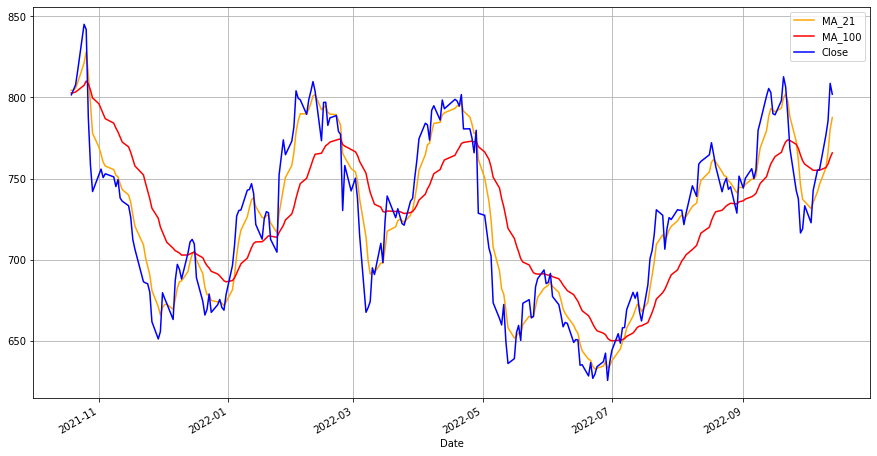

In [157]:

    x = backtesting("AXISBANK.NS",'1y','1d',5,25)
    print(x.returns())


In [144]:
data = x.data
data['ret_strat'] = 0.00
data['cumm_strat'] = 0.00
for i in range(0,len(data)-1):

    if data['position'][i] == 1: 
        
        if data['position'][i-1] == 0 or data['position'][i-1] == -1:
            data['ret_strat'][i] = 0
            data['ret_strat'][i+1] = np.log(data['Close'][i+1]/(data["Close"][i]))
            data['cumm_strat'][i+1] = data['cumm_strat'][i] + data['ret_strat'][i+1]
            if data['signal'][i] == 1: 
                data['cumm_strat'][i] = 0
                

        elif data['position'][i-1] == 1:
            data['ret_strat'][i+1] = np.log(data['Close'][i+1]/(data["Close"][i]))
            data['cumm_strat'][i+1] = data['cumm_strat'][i] + data['ret_strat'][i+1]
            if data['signal'][i] == 1: 
                data['cumm_strat'][i] = 0
            
    if data['position'][i] == -1:   
        
        if data['position'][i-1] == 0 or data['position'][i-1] == 1:
            data['ret_strat'][i] = 0
            data['ret_strat'][i+1] = np.log(data['Close'][i]/(data["Close"][i+1]))
            data['cumm_strat'][i+1] = data['cumm_strat'][i] + data['ret_strat'][i+1]
            if data['signal'][i] == 1: 
                data['cumm_strat'][i] = 0


        elif data['position'][i-1] == -1:
            data['ret_strat'][i+1] = np.log(data['Close'][i]/(data["Close"][i+1]))
            data['cumm_strat'][i+1] = data['cumm_strat'][i] + data['ret_strat'][i+1]
            if data['signal'][i] == 1: 
                data['cumm_strat'][i] = 0
 






In [146]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,daily_return,MA_21,MA_100,MA_21_prev,...,position,BUY_HOLD_return,Strategy_return,Cumm_BUY_HOLD_return,Cumm_Strategy_return,mean_strategy_return,var_strategy_return,Sharp_ratio,ret_strat,cumm_strat
count,245.000000,245.000000,245.000000,245.000000,245.000000,2.450000e+02,245.000000,245.000000,245.000000,245.000000,...,245.000000,245.000000,245.000000,245.000000,245.000000,2.450000e+02,2.450000e+02,2.450000e+02,245.000000,245.000000
mean,725.561838,734.227961,715.827957,724.939998,724.147310,1.034955e+07,0.000001,725.077273,726.750952,725.145911,...,-0.024490,0.000001,0.002510,-0.117585,0.376490,2.499390e-03,3.168374e-04,7.888557e+00,0.002972,0.370009
std,51.367922,51.784740,50.470179,51.556125,51.605016,5.434289e+06,0.018660,49.089242,39.434406,49.188677,...,0.991466,0.018660,0.017836,0.071428,0.207458,3.041981e-18,2.716054e-19,5.274147e-14,0.017346,0.212188
min,624.000000,633.650020,618.250000,625.549990,624.599240,7.934330e+05,-0.068670,632.581080,649.932210,632.581080,...,-1.000000,-0.068670,-0.038620,-0.262530,0.000000,2.499390e-03,3.168374e-04,7.888557e+00,-0.038619,0.000000
25%,679.099980,686.500000,671.000000,678.799990,677.768310,6.918584e+06,-0.009830,681.909420,696.224790,681.909420,...,-1.000000,-0.009830,-0.007980,-0.180790,0.176750,2.499390e-03,3.168374e-04,7.888557e+00,-0.007364,0.163009
50%,730.000000,736.000000,720.400020,728.599980,727.792180,9.353805e+06,0.000470,727.400990,729.707900,727.400990,...,-1.000000,0.000470,0.001390,-0.110040,0.356320,2.499390e-03,3.168374e-04,7.888557e+00,0.001093,0.353964
75%,765.000000,773.750000,753.400020,764.700010,764.650020,1.169485e+07,0.010960,761.814320,760.507320,761.814320,...,1.000000,0.010960,0.012680,-0.061640,0.553150,2.499390e-03,3.168374e-04,7.888557e+00,0.012257,0.551465
max,848.400020,866.900020,825.450010,845.099980,843.815550,3.960641e+07,0.065370,828.131000,810.148600,828.131000,...,1.000000,0.065370,0.068670,0.038350,0.718330,2.499390e-03,3.168374e-04,7.888557e+00,0.068668,0.718318


In [158]:
'''
data.to_csv("AXIS_BANK.csv")
hit_list = []

for i in range(0,len(data)):

    
    if data['signal'][i] == -1:

        hit_list.append(np.exp(data['cumm_strat'][i])-1)
        
    


data = data.round(3)
hit_list = pd.DataFrame(data = hit_list)
hit_list.cumsum()
'''
        


'\ndata.to_csv("AXIS_BANK.csv")\nhit_list = []\n\nfor i in range(0,len(data)):\n\n    \n    if data[\'signal\'][i] == -1:\n\n        hit_list.append(np.exp(data[\'cumm_strat\'][i])-1)\n        \n    \n\n\ndata = data.round(3)\nhit_list = pd.DataFrame(data = hit_list)\nhit_list.cumsum()\n'